# Import Library

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import glob
from skimage.feature import graycomatrix, graycoprops
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import warnings
from sklearn.impute import SimpleImputer

# Mengabaikan peringatan
warnings.filterwarnings("ignore")

# --- KONFIGURASI ---
# Ganti dengan path Anda
PATH_TRAINING = '/content/drive/MyDrive/Machine Learning/Dataset Sampah/training'
PATH_VALIDATION = '/content/drive/MyDrive/Machine Learning/Dataset Sampah/validation'

# Label harus SAMA PERSIS dengan nama folder di dalam training & validation
LABEL_KELAS = ["Kaca", "Kardus", "Plastik"]
UKURAN_GAMBAR = (200, 200) # Ukuran untuk menstandardisasi semua gambar

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preprocessing Gambar

In [ ]:
# --- FUNGSI-FUNGSI EKSTRAKSI FITUR (LANGKAH 1 & 2) ---

def ekstrak_fitur_warna(gambar_hsv):
    """Mengekstrak histogram warna dari channel H (Hue) dan S (Saturation)"""
    hist_hue = cv2.calcHist([gambar_hsv], [0], None, [16], [0, 180])
    cv2.normalize(hist_hue, hist_hue)
    hist_sat = cv2.calcHist([gambar_hsv], [1], None, [16], [0, 256])
    cv2.normalize(hist_sat, hist_sat)
    return np.concatenate([hist_hue, hist_sat]).flatten()

def ekstrak_fitur_tekstur(gambar_gray):
    """Mengekstrak fitur tekstur GLCM"""
    gambar_gray = (gambar_gray).astype(np.uint8)
    glcm = graycomatrix(gambar_gray, [5], [0], levels=256, symmetric=True, normed=True)

    fitur_tekstur = np.array([
        graycoprops(glcm, 'contrast')[0, 0],
        graycoprops(glcm, 'dissimilarity')[0, 0],
        graycoprops(glcm, 'homogeneity')[0, 0],
        graycoprops(glcm, 'energy')[0, 0],
        graycoprops(glcm, 'correlation')[0, 0]
    ])
    return fitur_tekstur

def ekstrak_fitur_bentuk(gambar_gray):
    """Mengekstrak fitur bentuk menggunakan Hu Moments"""
    _, thresh = cv2.threshold(gambar_gray, 127, 255, cv2.THRESH_BINARY)
    moments = cv2.moments(thresh)
    hu_moments = cv2.HuMoments(moments)
    # Log-transform untuk stabilitas numerik
    hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments))
    return hu_moments.flatten()

def proses_satu_gambar(path_gambar):
    """
    Fungsi utama untuk memproses satu gambar:
    Membaca -> Resize -> Konversi Warna -> Ekstrak Semua Fitur
    """
    try:
        # --- LANGKAH 1: PREPROCESSING ---
        img = cv2.imread(path_gambar)
        if img is None:
            print(f"Peringatan: Gagal memuat {path_gambar}")
            return None

        img_resized = cv2.resize(img, UKURAN_GAMBAR)

        # Konversi ruang warna
        img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
        img_hsv = cv2.cvtColor(img_resized, cv2.COLOR_BGR2HSV)

        # --- LANGKAH 2: EKSTRAKSI FITUR ---
        fitur_warna = ekstrak_fitur_warna(img_hsv)
        fitur_tekstur = ekstrak_fitur_tekstur(img_gray)
        fitur_bentuk = ekstrak_fitur_bentuk(img_gray)

        # Gabungkan semua fitur menjadi satu vektor
        vektor_fitur_global = np.hstack([fitur_warna, fitur_tekstur, fitur_bentuk])
        return vektor_fitur_global

    except Exception as e:
        print(f"Error memproses {path_gambar}: {e}")
        return None

##  Visualisasi Gambar

In [ ]:
# PENTING: Pastikan variabel ini didefinisikan sama seperti di skrip utama Anda
UKURAN_GAMBAR = (200, 200)

def visualisasikan_preprocessing(path_gambar):
    """
    Memuat satu gambar dan menampilkan semua langkah preprocessing
    (termasuk langkah segmentasi Otsu yang gagal).
    """

    print(f"Memvisualisasikan: {path_gambar}\n")

    # --- 1. Muat Gambar Asli ---
    img = cv2.imread(path_gambar)
    if img is None:
        print(f"Gagal memuat {path_gambar}")
        return
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Untuk plotting

    # --- 2. Resize ---
    img_resized = cv2.resize(img, UKURAN_GAMBAR)
    img_resized_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

    # --- 3. Grayscale (untuk Otsu) ---
    img_gray_for_mask = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

    # --- 4. Otsu Mask (Logika dari upaya terakhir kita) ---
    # Ini adalah langkah yang gagal pada latar belakang putih
    _, mask = cv2.threshold(img_gray_for_mask, 0, 255,
                            cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # --- 5. Hasil Segmentasi (Input untuk Fitur Warna) ---
    img_segmented = cv2.bitwise_and(img_resized, img_resized, mask=mask)
    img_segmented_rgb = cv2.cvtColor(img_segmented, cv2.COLOR_BGR2RGB)

    # --- 6. Grayscale (Input untuk Fitur Tekstur/Bentuk) ---
    # Ini adalah grayscale dari gambar yang (seharusnya) sudah bersih
    img_segmented_gray = cv2.cvtColor(img_segmented, cv2.COLOR_BGR2GRAY)

    # --- Mulai Plotting ---
    plt.figure(figsize=(20, 9))
    plt.suptitle("Visualisasi Langkah Preprocessing & Segmentasi", fontsize=16, y=1.02)

    plt.subplot(2, 3, 1)
    plt.imshow(img_rgb)
    plt.title("1. Gambar Asli")
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.imshow(img_resized_rgb)
    plt.title("2. Gambar di-Resize")
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.imshow(img_gray_for_mask, cmap='gray')
    plt.title("3. Grayscale (Input untuk Otsu)")
    plt.axis('off')

    plt.subplot(2, 3, 4)
    plt.imshow(mask, cmap='gray')
    plt.title("4. Mask Otsu (INI KUNCINYA)")
    plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.imshow(img_segmented_rgb)
    plt.title("5. Hasil Segmentasi (Input Fitur Warna)")
    plt.axis('off')

    plt.subplot(2, 3, 6)
    plt.imshow(img_segmented_gray, cmap='gray')
    plt.title("6. Grayscale (Input Fitur Tekstur/Bentuk)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

Memvisualisasikan: /content/drive/MyDrive/Machine Learning/Dataset Sampah/validation/Plastik/R_10477.jpg



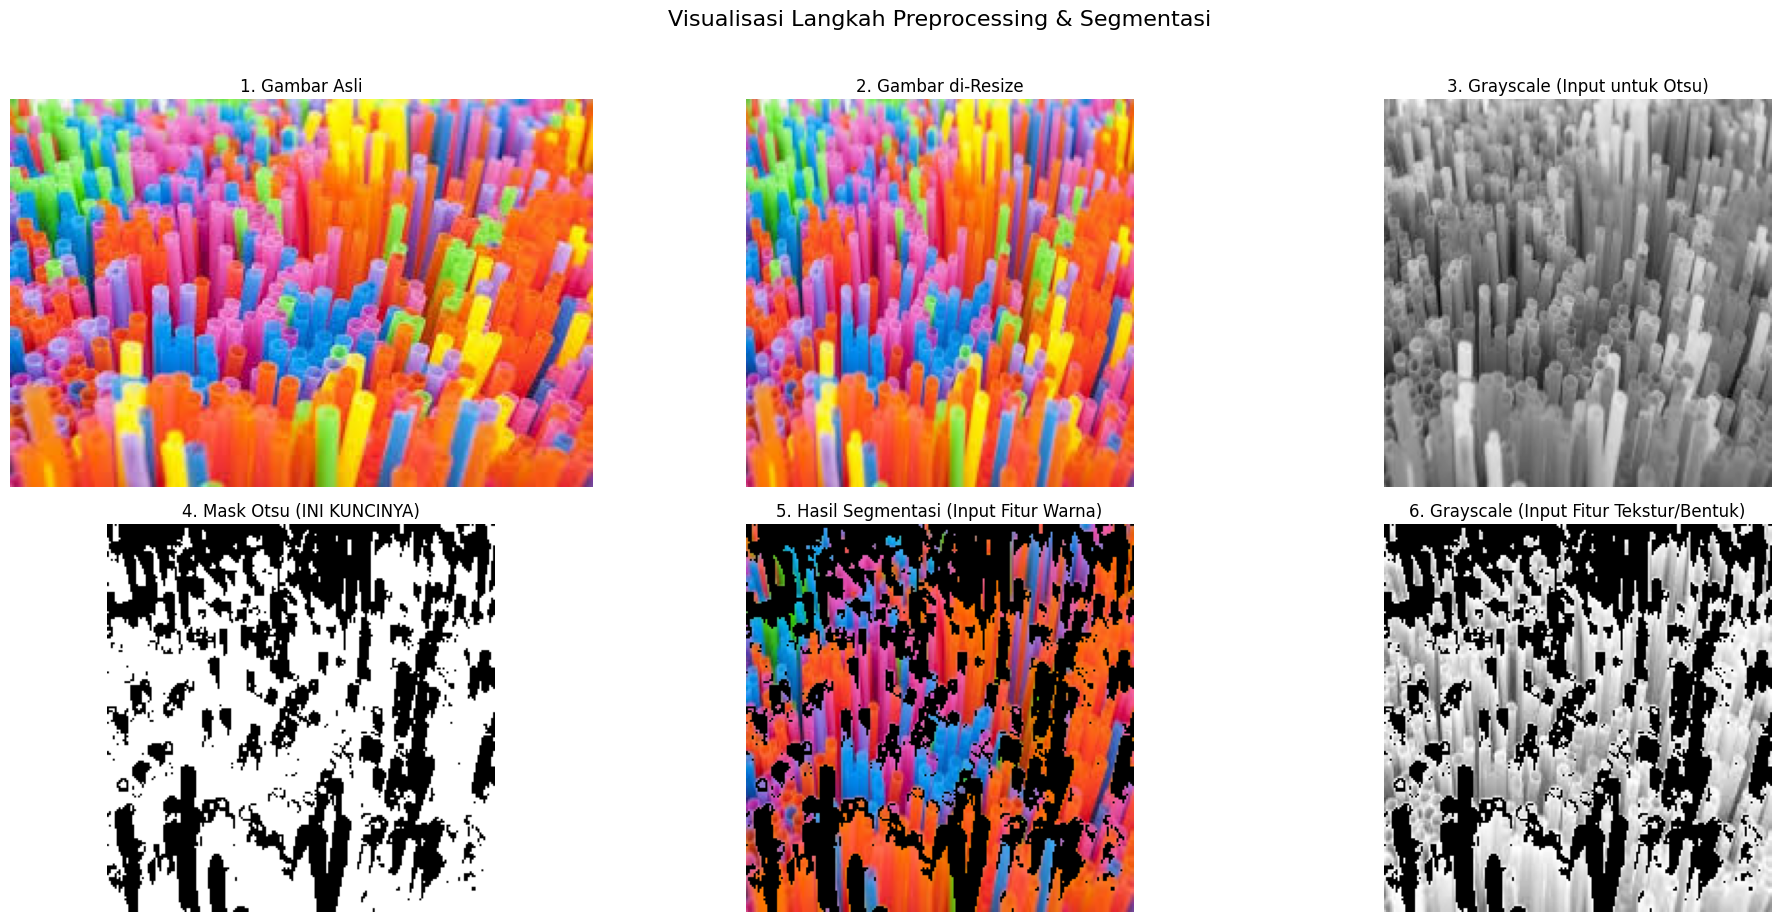

Memvisualisasikan: /content/drive/MyDrive/Machine Learning/Dataset Sampah/validation/Kardus/kardus (655).jpg



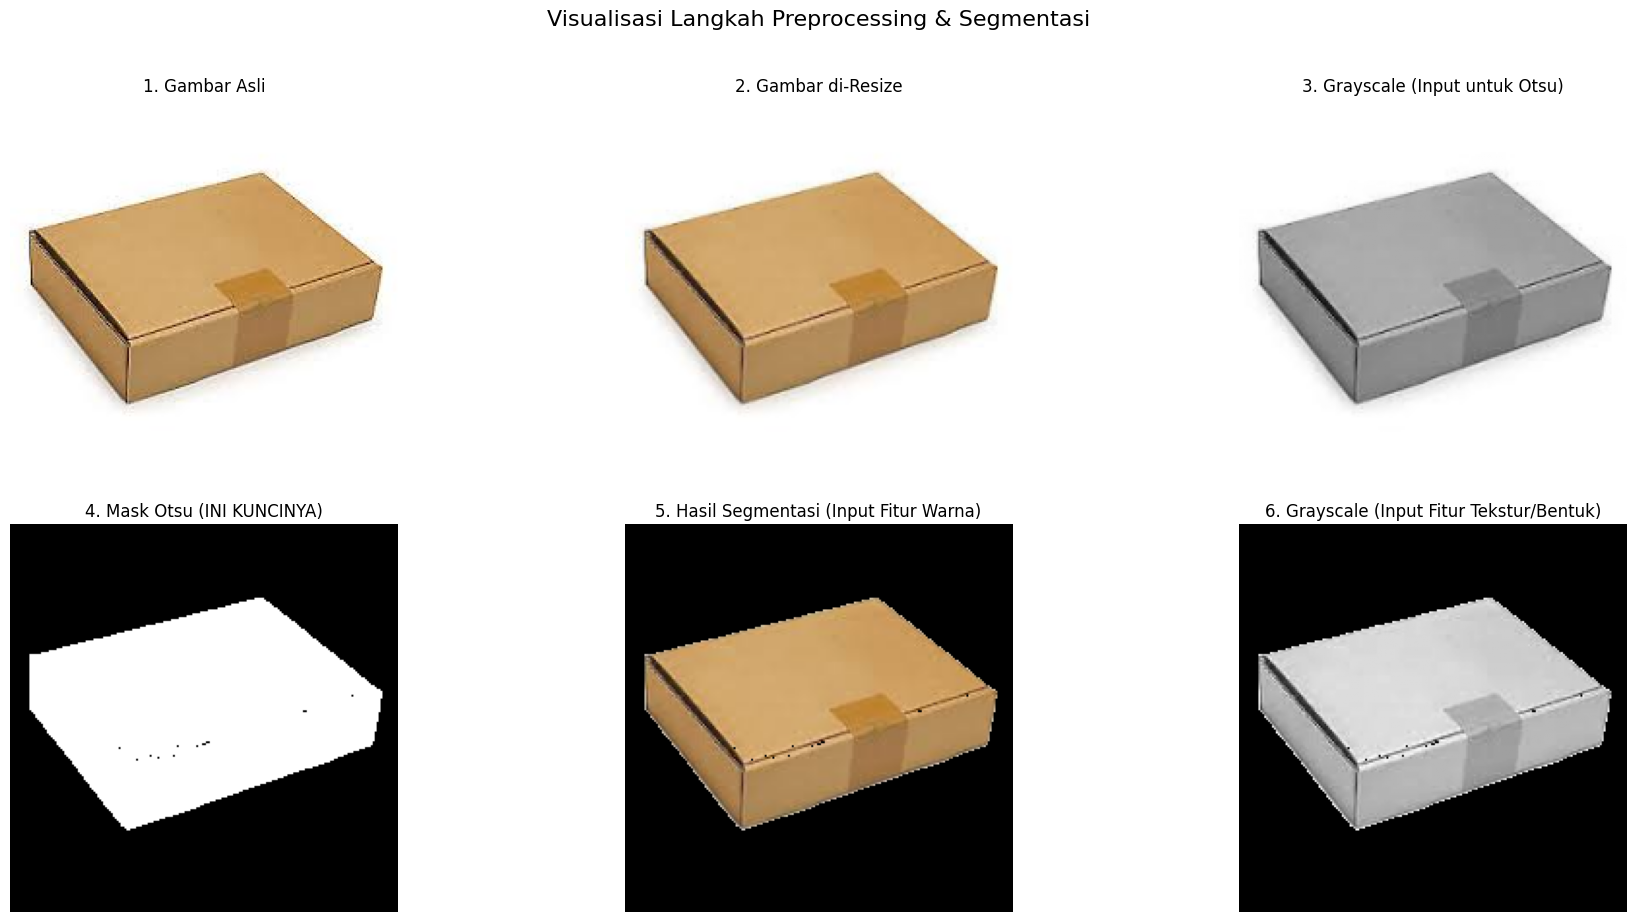

In [ ]:
# Ganti dengan path gambar dari output kesalahan Anda
path_sedotan_putih = "/content/drive/MyDrive/Machine Learning/Dataset Sampah/validation/Plastik/R_10477.jpg"
path_kotak_pizza = "/content/drive/MyDrive/Machine Learning/Dataset Sampah/validation/Kardus/kardus (655).jpg"

# Coba jalankan ini
visualisasikan_preprocessing(path_sedotan_putih)

# Coba jalankan ini juga
visualisasikan_preprocessing(path_kotak_pizza)

# Pembangunan Dataset

In [ ]:
# --- FUNGSI PEMBANGUN DATASET (LANGKAH 3) ---

def buat_dataset_dari_folder(base_path, kelas_list):
    """
    Membaca semua gambar dari 'base_path' (misal: .../training)
    dan mengembalikan X (fitur) dan y (label)
    """
    data_fitur = [] # Ini akan menjadi X
    data_label = [] # Ini akan menjadi y

    print(f"Memproses folder: {base_path}")

    for label_index, nama_kelas in enumerate(kelas_list):
        path_folder = os.path.join(base_path, nama_kelas)

        # Cari semua file gambar (jpg, png, jpeg) di dalam folder
        pola_path = os.path.join(path_folder, "*.*")
        daftar_gambar = [f for f in glob.glob(pola_path) if f.endswith((".jpg", ".png", ".jpeg"))]

        if not daftar_gambar:
            print(f"Peringatan: Tidak ada gambar di {path_folder}")
            continue

        print(f"-> Memproses {len(daftar_gambar)} gambar untuk kelas: {nama_kelas}")

        for path_gambar in daftar_gambar:
            vektor_fitur = proses_satu_gambar(path_gambar)

            if vektor_fitur is not None:
                data_fitur.append(vektor_fitur)
                data_label.append(label_index) # Label adalah 0, 1, atau 2

    # Ubah ke NumPy array
    X = np.array(data_fitur)
    y = np.array(data_label)

    return X, y

Memproses folder: /content/drive/MyDrive/Machine Learning/Dataset Sampah/training
-> Memproses 860 gambar untuk kelas: Kaca
-> Memproses 479 gambar untuk kelas: Kardus
-> Memproses 960 gambar untuk kelas: Plastik
Memproses folder: /content/drive/MyDrive/Machine Learning/Dataset Sampah/validation
-> Memproses 301 gambar untuk kelas: Kaca
-> Memproses 236 gambar untuk kelas: Kardus
-> Memproses 276 gambar untuk kelas: Plastik

-----------------------------------------
Data Latih: 2299 sampel
Data Validasi: 813 sampel
Panjang Fitur: 44
-----------------------------------------
Menjalankan Imputer untuk mengganti NaN (jika ada)...
Imputer selesai.
Melakukan normalisasi fitur (StandardScaler)...
Normalisasi selesai.
Mulai melatih model SVM (Kernel RBF)...
Pelatihan model SVM selesai.
-----------------------------------------
Mengevaluasi model pada data validasi...

LAPORAN KLASIFIKASI (VALIDATION SET):
              precision    recall  f1-score   support

        Kaca       0.61      0.73

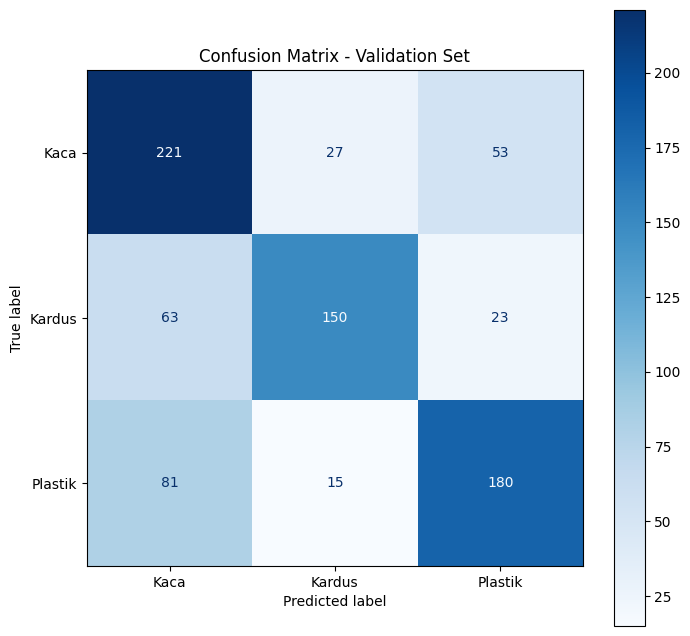


Proses selesai.


In [ ]:
# ===================================================================
# PROSES UTAMA (TRAINING & EVALUASI)
# ===================================================================

# 1. Buat Dataset Training
X_train, y_train = buat_dataset_dari_folder(PATH_TRAINING, LABEL_KELAS)

# 2. Buat Dataset Validasi/Test
X_val, y_val = buat_dataset_dari_folder(PATH_VALIDATION, LABEL_KELAS)

print("\n-----------------------------------------")
print(f"Data Latih: {len(X_train)} sampel")
print(f"Data Validasi: {len(X_val)} sampel")
print(f"Panjang Fitur: {X_train.shape[1]}")
print("-----------------------------------------")

# =PENTING: TAMBAHKAN BLOK INI UNTUK MENGHAPUS NaN ============
print("Menjalankan Imputer untuk mengganti NaN (jika ada)...")
imputer = SimpleImputer(strategy='mean')

# Kita fit_transform pada data latih
X_train = imputer.fit_transform(X_train)

# Kita HANYA transform pada data validasi
X_val = imputer.transform(X_val)
print("Imputer selesai.")
# ===================================================================
# LANGKAH 4: NORMALISASI FITUR (SCALING)
# ===================================================================

print("Melakukan normalisasi fitur (StandardScaler)...")
scaler = StandardScaler()

# PENTING: Kita 'fit' (belajar) HANYA pada data training
X_train_scaled = scaler.fit_transform(X_train)

# Kita 'transform' (menerapkan) HANYA pada data validasi
# Ini untuk menghindari 'kebocoran data' dari set validasi
X_val_scaled = scaler.transform(X_val)

print("Normalisasi selesai.")

# ===================================================================
# LANGKAH 6: PEMBANGUNAN MODEL SVM
# ===================================================================

print("Mulai melatih model SVM (Kernel RBF)...")
model_svm = SVC(kernel='rbf', C=1.0, probability=True, random_state=42)
model_svm.fit(X_train_scaled, y_train)

print("Pelatihan model SVM selesai.")
print("-----------------------------------------")

# ===================================================================
# LANGKAH 7: EVALUASI MODEL
# ===================================================================

print("Mengevaluasi model pada data validasi...")

# Lakukan prediksi pada data validasi
y_pred = model_svm.predict(X_val_scaled)

# Tampilkan laporan klasifikasi (Precision, Recall, F1-Score)
print("\nLAPORAN KLASIFIKASI (VALIDATION SET):")
print(classification_report(y_val, y_pred, target_names=LABEL_KELAS))
print("-----------------------------------------")

# Tampilkan Confusion Matrix
print("Menampilkan Confusion Matrix...")
fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay.from_predictions(y_val, y_pred, ax=ax, display_labels=LABEL_KELAS, cmap='Blues')
ax.set_title("Confusion Matrix - Validation Set")
plt.show()

# Selesai
print("\nProses selesai.")